In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
cp_path = "/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/profiles/mad_featselect.parquet"
dino_path = "/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet"
cpcnn_path = "/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cpcnn/mad_featselect/profiles/mad_featselect.parquet"

In [3]:
def train_model(df, feat_cols, split_group, results_path, pred_vars, mean_pred = "no"):
    results = []
    for var in pred_vars:

        # Group split logic
        groups = df[split_group]
        gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        
        for split_idx, (train_idx, test_idx) in tqdm(enumerate(gss.split(df, groups=groups)), desc=f"Processing {var}"):
            # Splitting the dataset
            train_data = df.iloc[train_idx]
            test_data = df.iloc[test_idx]

            train_data = train_data.dropna(subset=[var]).reset_index(drop=True)
            test_data = test_data.dropna(subset=[var]).reset_index(drop=True)
            
            X_train = train_data[feat_cols]
            y_train = train_data[var]
            X_test = test_data[feat_cols]
            y_test = test_data[var]

            # Hyperparameter tuning
            model = xgb.XGBRegressor(objective="reg:squarederror")
            model.fit(X_train, y_train)

            if mean_pred == "yes":
                mean_value = np.mean(y_train)
                predictions = np.full(len(y_test), mean_value)
            else: 
                predictions = model.predict(X_test)

            # Calculate performance
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)

            # Log results
            #print(f"Variable: {var}, Split: {split_idx}, R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
            results.append((var, split_idx, r2, rmse, mae))

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results, columns=["Variable", "Split", "R²", "RMSE", "MAE"])

    # Save results
    results_df.to_csv(results_path, index=False)

In [4]:
def train_model_nozero(df, feat_cols, split_group, results_path, pred_vars, mean_pred = "no"):
    results = []
    for var in pred_vars:

        if "mtt" in var:
            nozero_df = df[df[var] < 1].reset_index(drop=True)
        else:
            nozero_df = df[df[var] > 0].reset_index(drop=True)

        # Group split logic
        groups = nozero_df[split_group]
        gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        
        for split_idx, (train_idx, test_idx) in tqdm(enumerate(gss.split(nozero_df, groups=groups)), desc=f"Processing {var}"):
            # Splitting the dataset
            train_data = nozero_df.iloc[train_idx]
            test_data = nozero_df.iloc[test_idx]

            train_data = train_data.dropna(subset=[var]).reset_index(drop=True)
            test_data = test_data.dropna(subset=[var]).reset_index(drop=True)
            
            X_train = train_data[feat_cols]
            y_train = train_data[var]
            X_test = test_data[feat_cols]
            y_test = test_data[var]

            # Hyperparameter tuning
            model = xgb.XGBRegressor(objective="reg:squarederror")
            model.fit(X_train, y_train)

            if mean_pred == "yes":
                mean_value = np.mean(y_train)
                predictions = np.full(len(y_test), mean_value)
            else: 
                predictions = model.predict(X_test)
            
            # Calculate performance
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)

            # Log results
            #print(f"Variable: {var}, Split: {split_idx}, R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
            results.append((var, split_idx, r2, rmse, mae))

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results, columns=["Variable", "Split", "R²", "RMSE", "MAE"])

    # Save results
    results_df.to_csv(results_path, index=False)

In [5]:
def process_prof(dat_path):
    df = pd.read_parquet(dat_path)
    morph_feats = [i for i in df.columns if "Metadata" not in i]
    meta_feats = [i for i in df.columns if "Metadata" in i]

    df = df[df["Metadata_Perturbation"] != "DMSO_0.0"].reset_index(drop=True)

    df["Metadata_Log10Conc"] = np.round(df["Metadata_Log10Conc"], 2)

    # Encoding categorical columns
    df["Metadata_Plate"] = df["Metadata_Plate"].astype("category").cat.codes
    df["Metadata_source"] = df["Metadata_source"].astype("category").cat.codes
    df["Metadata_Well"] = df["Metadata_Well"].astype("category").cat.codes
    df["Metadata_Compound"] = df["Metadata_Compound"].astype("category").cat.codes

    return df


In [6]:
# Process input data
cp_df = process_prof(cp_path)
dino_df = process_prof(dino_path)
cpcnn_df = process_prof(cpcnn_path)

## For normalized

In [ ]:
# Generate all results

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Log10Conc", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 1")


train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 2")

train_model(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 3")

train_model(df, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 4")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 5")

train_model(df, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 6")

train_model(df, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 7")

train_model(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 8")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 9")

train_model(df, 
            morph_feats,
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 10")

Processing Metadata_ldh_normalized: 5it [00:02,  1.91it/s]
Processing Metadata_mtt_normalized: 5it [00:03,  1.37it/s]

Done 1


In [ ]:
import pandas as pd

# Load the datasets
file_paths = [
    "baseline_results/grouped_results_compound_split_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_well_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_results/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_results/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

Metadata_ldh_normalized


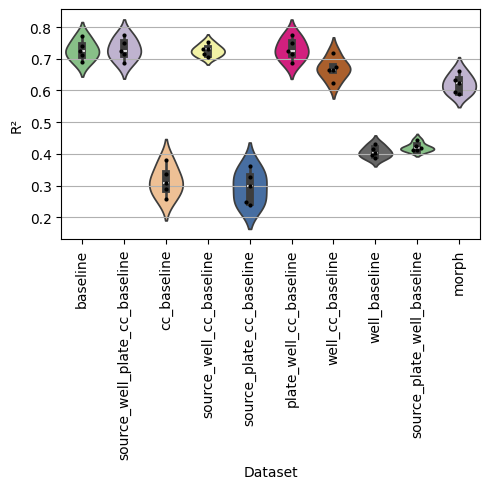

Metadata_ldh_normalized


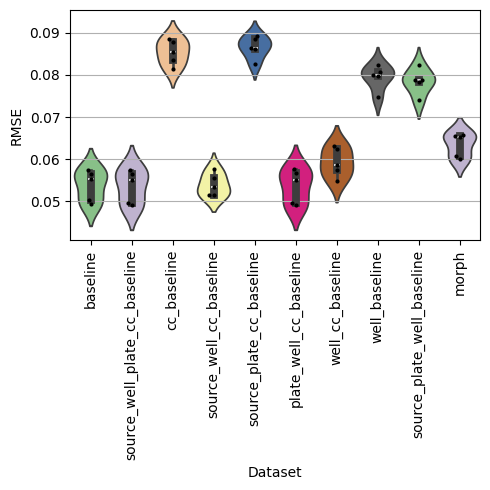

Metadata_ldh_normalized


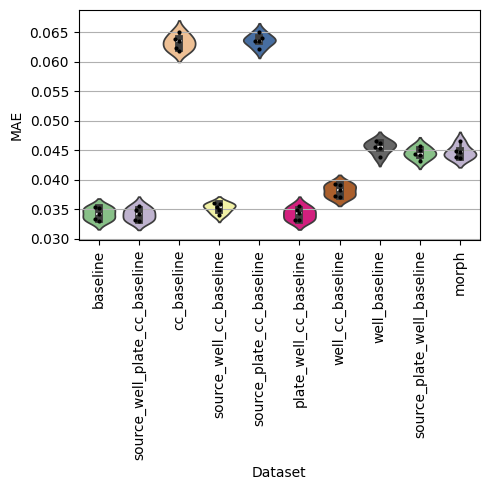

Metadata_mtt_normalized


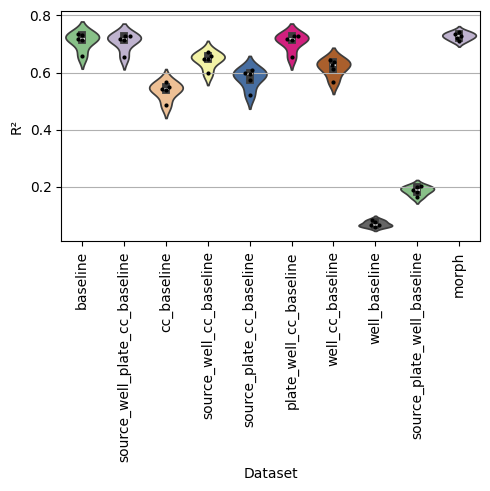

Metadata_mtt_normalized


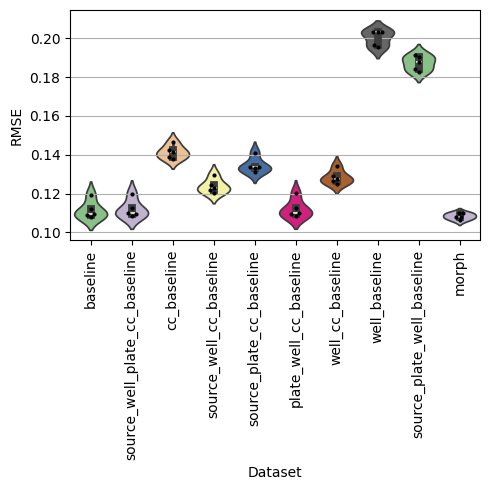

Metadata_mtt_normalized


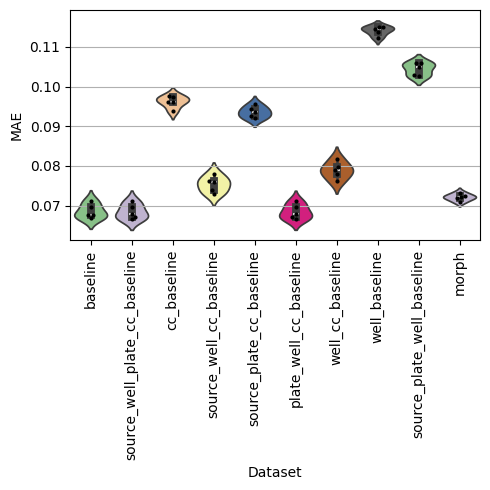

In [17]:
import seaborn as sns

# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels):
    combined_data = []
    for label, df in dataframes.items():
        # Filter rows based on the variable type
        filtered_df = df[df['Variable'].str.contains(variable_type)]
        if metric in metrics:
            for index, value in filtered_df[metric].items():
                combined_data.append({"Dataset": label.split('/')[-1], "Variable": variable_type, metric: value})
    
    # Convert combined data to DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=combined_df, x="Dataset", y=metric, inner="box", palette="Accent", hue="Dataset", legend=False)
    sns.swarmplot(data=combined_df, x="Dataset", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
# Generate plots for both variable types
variable_types = ['Metadata_ldh_normalized', 'Metadata_mtt_normalized']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)


## For ridge-norm

In [25]:
# Generate all results

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Log10Conc", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 1")


train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 2")

train_model(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 3")

train_model(df, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 4")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 5")

train_model(df, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 6")

train_model(df, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 7")

train_model(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 8")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 9")

train_model(df, 
            morph_feats,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 10")

Processing Metadata_ldh_ridge_norm: 5it [00:04,  1.10it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.74it/s]


Done 1


Processing Metadata_ldh_ridge_norm: 5it [00:04,  1.03it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:03,  1.63it/s]


Done 2


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.64it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.68it/s]


Done 3


Processing Metadata_ldh_ridge_norm: 5it [00:12,  2.40s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.90it/s]


Done 4


Processing Metadata_ldh_ridge_norm: 5it [00:04,  1.21it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:04,  1.22it/s]


Done 5


Processing Metadata_ldh_ridge_norm: 5it [00:02,  1.87it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:09,  1.85s/it]


Done 6


Processing Metadata_ldh_ridge_norm: 5it [00:02,  1.89it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:06,  1.22s/it]


Done 7


Processing Metadata_ldh_ridge_norm: 5it [00:11,  2.33s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:01,  2.80it/s]


Done 8


Processing Metadata_ldh_ridge_norm: 5it [00:06,  1.23s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  2.19it/s]


Done 9


Processing Metadata_ldh_ridge_norm: 5it [01:08, 13.75s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:45,  9.10s/it]

Done 10


In [26]:
import pandas as pd

# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

Metadata_ldh_ridge_norm


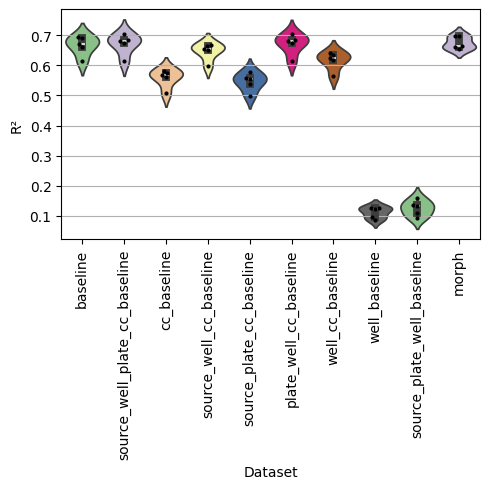

Metadata_ldh_ridge_norm


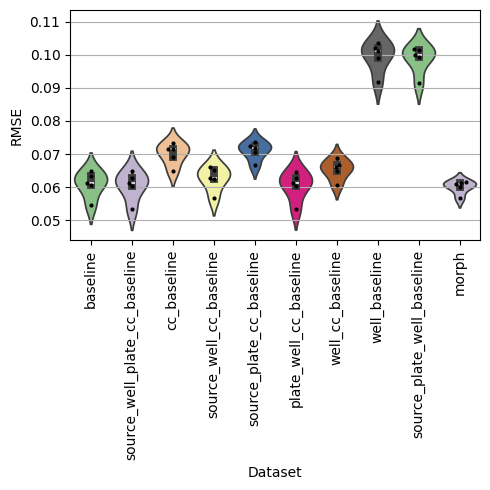

Metadata_ldh_ridge_norm


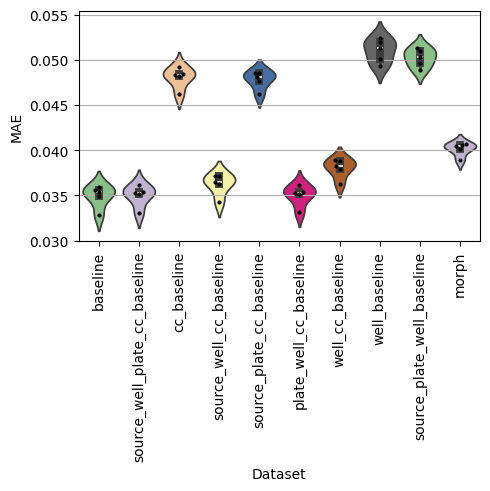

Metadata_mtt_ridge_norm


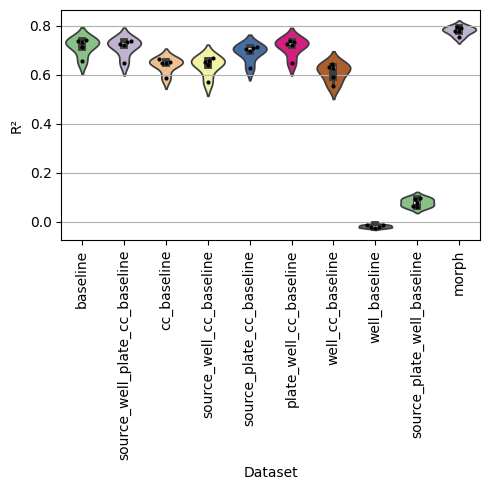

Metadata_mtt_ridge_norm


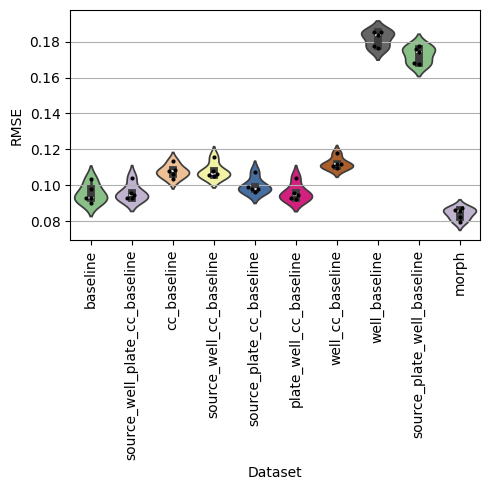

Metadata_mtt_ridge_norm


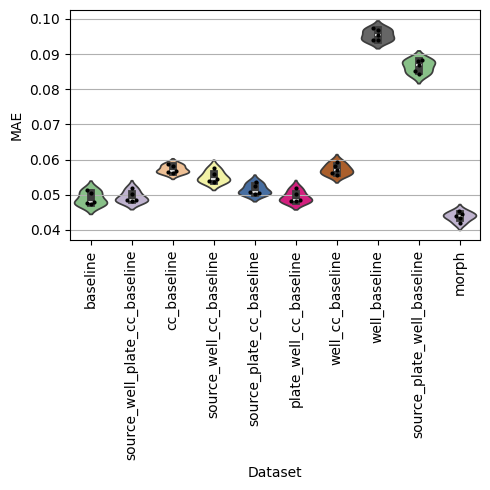

In [29]:
import seaborn as sns

# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels):
    combined_data = []
    for label, df in dataframes.items():
        # Filter rows based on the variable type
        filtered_df = df[df['Variable'].str.contains(variable_type)]
        if metric in metrics:
            for index, value in filtered_df[metric].items():
                combined_data.append({"Dataset": label.split('/')[-1], "Variable": variable_type, metric: value})
    
    # Convert combined data to DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=combined_df, x="Dataset", y=metric, inner="box", palette="Accent", hue="Dataset", legend=False)
    sns.swarmplot(data=combined_df, x="Dataset", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
# Generate plots for both variable types
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)


### Ridgenorm no zero

In [6]:
# Generate all results

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'],
            "yes")
print("Done 1")


train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 2")

train_model_nozero(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 3")

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 4")

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 5")

train_model_nozero(df, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 6")

train_model_nozero(df, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 7")

train_model_nozero(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 8")

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 9")

train_model_nozero(df, 
            morph_feats,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 10")

Processing Metadata_ldh_ridge_norm: 5it [00:43,  8.65s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:03,  1.51it/s]


Done 1


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.41it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:04,  1.13it/s]


Done 2


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.45it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  2.14it/s]


Done 3


Processing Metadata_ldh_ridge_norm: 5it [00:04,  1.06it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.71it/s]


Done 4


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.52it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  2.06it/s]


Done 5


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.63it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:03,  1.39it/s]


Done 6


Processing Metadata_ldh_ridge_norm: 5it [00:13,  2.69s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:15,  3.02s/it]


Done 7


Processing Metadata_ldh_ridge_norm: 5it [01:29, 17.97s/it]
Processing Metadata_mtt_ridge_norm: 5it [01:27, 17.45s/it]


Done 8


Processing Metadata_ldh_ridge_norm: 5it [00:38,  7.74s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:05,  1.00s/it]


Done 9


Processing Metadata_ldh_ridge_norm: 5it [01:08, 13.64s/it]
Processing Metadata_mtt_ridge_norm: 5it [01:00, 12.06s/it]

Done 10


In [ ]:
# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

Metadata_ldh_ridge_norm


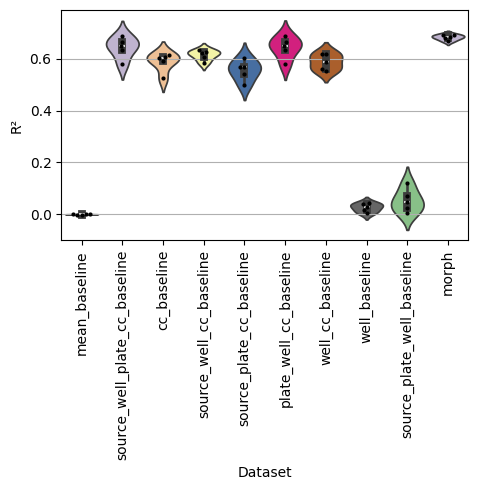

Metadata_ldh_ridge_norm


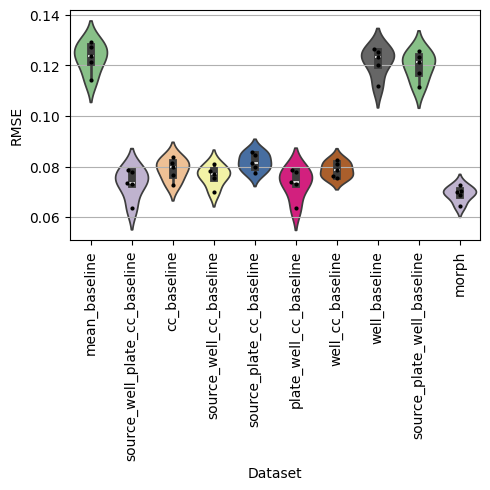

Metadata_ldh_ridge_norm


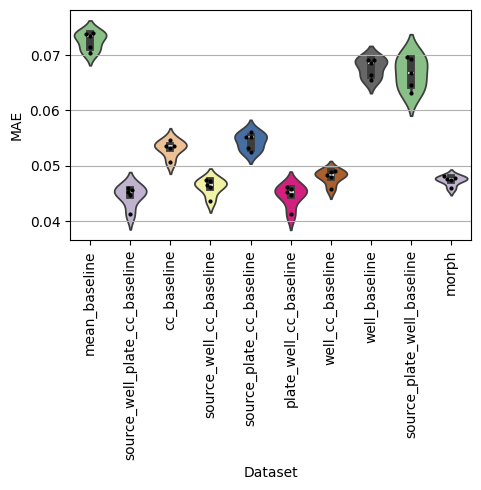

Metadata_mtt_ridge_norm


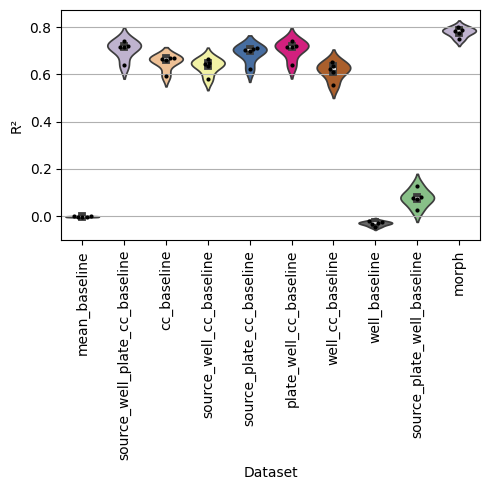

Metadata_mtt_ridge_norm


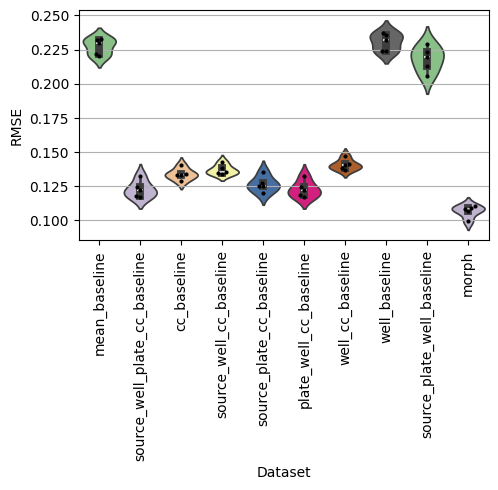

Metadata_mtt_ridge_norm


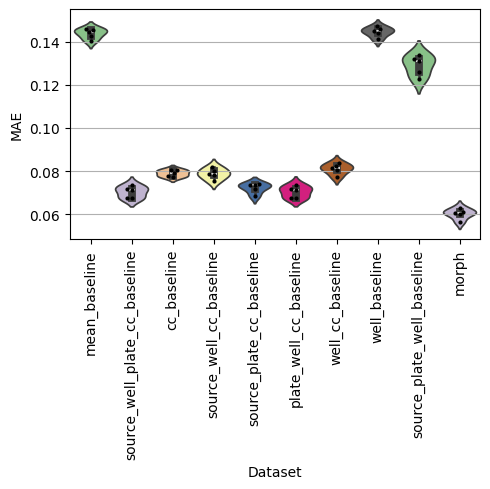

In [10]:
import seaborn as sns

# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels):
    combined_data = []
    for label, df in dataframes.items():
        # Filter rows based on the variable type
        filtered_df = df[df['Variable'].str.contains(variable_type)]
        if metric in metrics:
            for index, value in filtered_df[metric].items():
                combined_data.append({"Dataset": label.split('/')[-1], "Variable": variable_type, metric: value})
    
    # Convert combined data to DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=combined_df, x="Dataset", y=metric, inner="box", palette="Accent", hue="Dataset", legend=False)
    sns.swarmplot(data=combined_df, x="Dataset", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
# Generate plots for both variable types
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)

<Axes: >

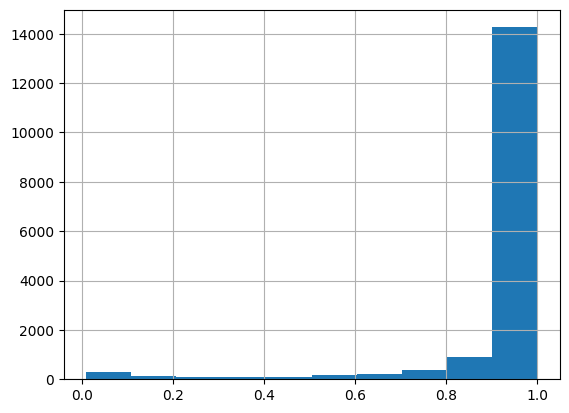

In [37]:
df.Metadata_mtt_ridge_norm.hist()

<Axes: >

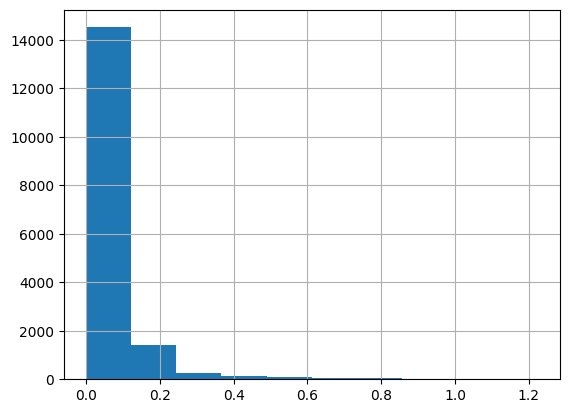

In [38]:
df.Metadata_ldh_ridge_norm.hist()

## With profile well-position correction

In [13]:
import polars as pl

df_well = pl.from_pandas(df)
df_well = df_well.with_columns(pl.col(morph_feats) - pl.mean(morph_feats).over("Metadata_Well")).to_pandas()


In [15]:
# Generate all results

train_model_nozero(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'],
            "yes")
print("Done 1")


train_model_nozero(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 2")

train_model_nozero(df_well, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 3")

train_model_nozero(df_well, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 4")

train_model_nozero(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 5")

train_model_nozero(df_well, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 6")

train_model_nozero(df_well, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 7")

train_model_nozero(df_well, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 8")

train_model_nozero(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 9")

train_model_nozero(df_well, 
            morph_feats,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 10")

Processing Metadata_ldh_ridge_norm: 5it [00:10,  2.09s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.84it/s]


Done 1


Processing Metadata_ldh_ridge_norm: 5it [00:02,  1.77it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.69it/s]


Done 2


Processing Metadata_ldh_ridge_norm: 5it [00:02,  1.99it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:48,  9.63s/it]


Done 3


Processing Metadata_ldh_ridge_norm: 5it [01:00, 12.01s/it]
Processing Metadata_mtt_ridge_norm: 5it [00:40,  8.13s/it]


Done 4


Processing Metadata_ldh_ridge_norm: 5it [00:02,  2.27it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.80it/s]


Done 5


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.55it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:01,  2.74it/s]


Done 6


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.35it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:02,  1.74it/s]


Done 7


Processing Metadata_ldh_ridge_norm: 5it [00:02,  2.22it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:01,  2.56it/s]


Done 8


Processing Metadata_ldh_ridge_norm: 5it [00:03,  1.58it/s]
Processing Metadata_mtt_ridge_norm: 5it [00:03,  1.67it/s]


Done 9


Processing Metadata_ldh_ridge_norm: 5it [01:01, 12.37s/it]
Processing Metadata_mtt_ridge_norm: 5it [01:24, 16.84s/it]

Done 10


Metadata_ldh_ridge_norm


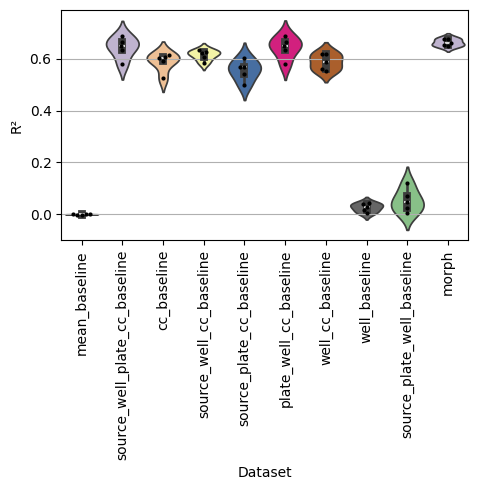

Metadata_ldh_ridge_norm


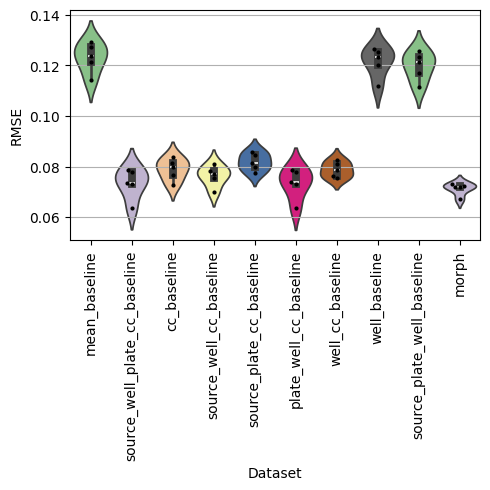

Metadata_ldh_ridge_norm


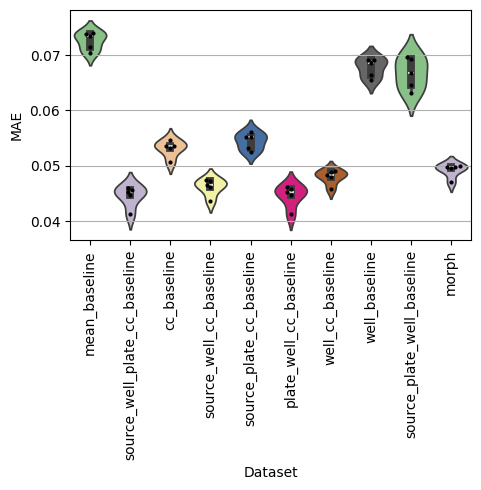

Metadata_mtt_ridge_norm


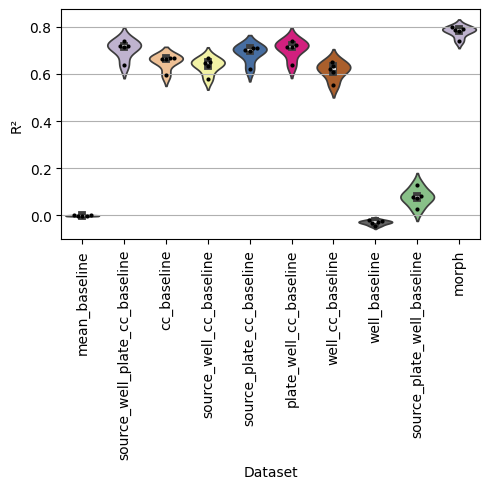

Metadata_mtt_ridge_norm


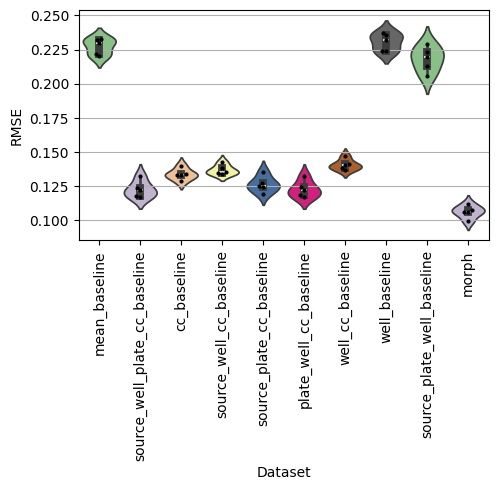

Metadata_mtt_ridge_norm


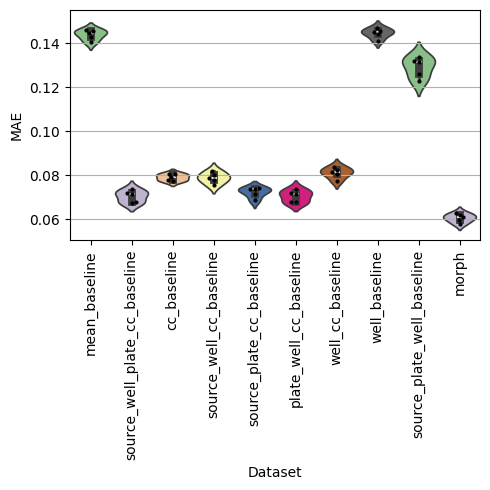

In [16]:
# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels):
    combined_data = []
    for label, df in dataframes.items():
        # Filter rows based on the variable type
        filtered_df = df[df['Variable'].str.contains(variable_type)]
        if metric in metrics:
            for index, value in filtered_df[metric].items():
                combined_data.append({"Dataset": label.split('/')[-1], "Variable": variable_type, metric: value})
    
    # Convert combined data to DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=combined_df, x="Dataset", y=metric, inner="box", palette="Accent", hue="Dataset", legend=False)
    sns.swarmplot(data=combined_df, x="Dataset", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
# Generate plots for both variable types
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)

## Subtract mean of MTT and LDH normalized values

In [17]:
df_well = pl.from_pandas(df)
df_well = df_well.with_columns(pl.col(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']) - pl.mean(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']).over("Metadata_Well")).to_pandas()

In [18]:
# Generate all results

train_model(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'],
            "yes")
print("Done 1")


train_model(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 2")

train_model(df_well, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 3")

train_model(df_well, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 4")

train_model(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 5")

train_model(df_well, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 6")

train_model(df_well, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 7")

train_model(df_well, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 8")

train_model(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 9")

train_model(df_well, 
            morph_feats,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 10")

Processing Metadata_ldh_normalized: 5it [01:18, 15.71s/it]
Processing Metadata_mtt_normalized: 3it [01:01, 20.65s/it]


KeyboardInterrupt: 

In [ ]:
# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels):
    combined_data = []
    for label, df in dataframes.items():
        # Filter rows based on the variable type
        filtered_df = df[df['Variable'].str.contains(variable_type)]
        if metric in metrics:
            for index, value in filtered_df[metric].items():
                combined_data.append({"Dataset": label.split('/')[-1], "Variable": variable_type, metric: value})
    
    # Convert combined data to DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=combined_df, x="Dataset", y=metric, inner="box", palette="Accent", hue="Dataset", legend=False)
    sns.swarmplot(data=combined_df, x="Dataset", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
# Generate plots for both variable types
variable_types = ['Metadata_ldh_normalized', 'Metadata_mtt_normalized']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)